In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from CLEARview import lattice, aperture, elements, opticsUtils, plot

In [2]:
# Relativistic parametres (from the plasmaDefocus using CLEARview)
P0 = 200                      #[MeV]
m0c2 = 511e-03                #[MeV]
E0 = np.sqrt(m0c2**2 + P0**2) #[MeV]

# Initial twiss parametres 
N = 200         # Number of particles
epsn_x = 10.0   #[um]
epsn_y = 10.0   #[um]

# Find geometrical emittance
epsg_x = opticsUtils.get_eps_g(epsn_x,E0) 
epsg_y = opticsUtils.get_eps_g(epsn_y,E0) 

# Constraints in Plasma lens
#sigma_PL = 0.2e-03     #[m]
alpha_PL = 0.0

# Initial beta and alpha in the position of the Plasma lens
beta0x = 0.5
alpha0x = alpha_PL
beta0y = 0.5
alpha0y = alpha_PL

x0 = 0.0  #[mm]
y0 = 0.0  #[1e-3]
xp0 = 0.0 #[mm]
yp0 = 0.0 #[1e-3]

In [22]:
from CLEARview import clearST_survey0_tfs #get the lattice

# Fix the setup of the quadrupoles
latticeCLEAR = clearST_survey0_tfs.buildLattice(P0, doFinalize=False)
sPLE = latticeCLEAR.getElemS('PLE0800M') # Get the position of the middle of the plasmalens
latticeCLEAR.implicitSeq_removeElem('CA.DHJ0780') # Remove kicker magnet from the setup
latticeCLEAR.implicitSeq_removeElem('BTV0800') # Remove to avoid overlapping elements when adding PLE
#latticeCLEAR.implicitSeq_removeElem('PLE0800M') # Remove the marker for the plasmalens
latticeCLEAR.implicitSeq_removeElem('CA.DHJ0840') # Remove kicker magnet from the setup
latticeCLEAR.implicitSeq_addElem(elements.CLEAR_Q(0.0, P0), 'QFD0860', 16.2625, refer='end', referFrom=None) # Add focusing magnet
latticeCLEAR.implicitSeq_addElem(elements.Marker(),'PLE_start', sPLE-0.01) #Mark the start of the plasmalens 
latticeCLEAR.implicitSeq_addElem(elements.Marker(),'PLE_end',sPLE+0.01) #Mark the end of the plasmalens
#latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Start', 14.400)
print(sPLE)
# Remove some markers for a simpler setup (easier to read the plot)
latticeCLEAR.implicitSeq_removeElem('CA.QS0870')
latticeCLEAR.implicitSeq_removeElem('CA.CLEAR$END')
latticeCLEAR.implicitSeq_removeElem('CA.CLDUMP$START')
latticeCLEAR.implicitSeq_removeElem('CA.VAW0915')
latticeCLEAR.implicitSeq_removeElem('CA.ICT0930')
latticeCLEAR.implicitSeq_removeElem('CLDUMP$END')
latticeCLEAR.implicitSeq_removeElem('CA.BTV0910') # Fjernet pga jeg får trøbbel med optimeringen 
    #latticeCLEAR.implicitSeq_finalize()

# Add markers for different focal points
#latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', 18.1815) # Dette er fokuspunktet som er symmetrisk
latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', 18.1815)
#latticeCLEAR.implicitSeq_finalize()

# ADD PLASMALENS
I4 = 0.0
#latticeCLEAR.implicitSeq_addElem( elements.CLEAR_PlasmaLens( 20e-3, 0.50, I4, P0 ), 'PLE0800', sPLE)

latticeCLEAR.implicitSeq_finalize()

latticeCLEAR_PLE = latticeCLEAR.getSubLattice('PLE_start', 'PLE_end')

print("Position of PLE_start:",15.007499999999999)
print(sPLE-0.01)

15.017499999999998
Position of PLE_start: 15.007499999999999
15.007499999999999


## Backpropagate from middle of APL (without APL present)

XM: [[ 1.e+00 -2.e-02  1.e-04]
 [ 0.e+00  1.e+00 -1.e-02]
 [ 0.e+00  0.e+00  1.e+00]]
YM: [[ 1.e+00 -2.e-02  1.e-04]
 [ 0.e+00  1.e+00 -1.e-02]
 [ 0.e+00  0.e+00  1.e+00]]
[15.0075 15.0075 15.0175 15.0175 15.0275 15.0275]
[15.0075     15.0075     15.00861111 15.00972222 15.01083333 15.01194444
 15.01305556 15.01416667 15.01527778 15.01638889 15.0175     15.0175
 15.01861111 15.01972222 15.02083333 15.02194444 15.02305556 15.02416667
 15.02527778 15.02638889 15.0275     15.0275    ]


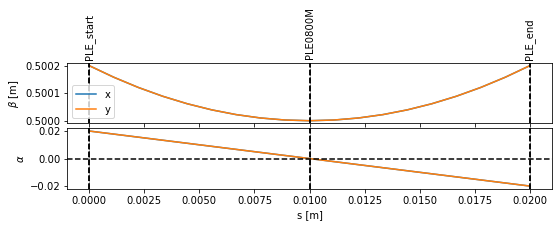

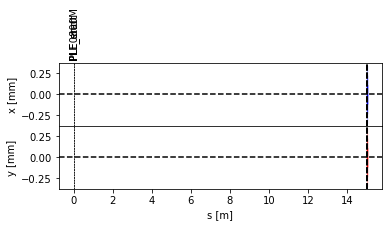

#  s[m] element_name         typeName            betax[m] betay[m]         alphax[m]        alphay[m] sigmax[mm] sigmay[mm]    x[mm]    y[mm]    dx/ds[1e-3]    dy/ds[1e-3]
###########################################################################################################################################################################
    0.0 START                -----                 0.5002   0.5002              0.02             0.02    0.11312    0.11312      0.0      0.0            0.0            0.0
    0.0 PLE_start            Marker                0.5002   0.5002              0.02             0.02    0.11312    0.11312      0.0      0.0            0.0            0.0
   0.01 drift_23             Drift                    0.5      0.5               0.0              0.0     0.1131     0.1131      0.0      0.0            0.0            0.0
   0.01 PLE0800M             Marker                   0.5      0.5               0.0              0.0     0.1131     0.1131      0.0      0.

In [24]:
beta0x=beta0y=0.5
alpha0x=alpha0y=0.0
pos_PLE = sPLE-0.01
# Backpropagate from middle of plasma lens to start of plasmalens in order to find beta and alpha

#Backpropagate optics from Focal point to start of triplet
(XM,YM) = latticeCLEAR_PLE.getTwissMatrix(firstElem="PLE_start",lastElem="PLE0800M",lastElemExclusive=False)
print('XM:', XM)
print('YM:', YM)

# Twiss matrix for propagating
xt_init = np.asarray([beta0x, alpha0x, opticsUtils.getGamma(alpha0x,beta0x)])
yt_init = np.asarray([beta0y, alpha0y, opticsUtils.getGamma(alpha0y,beta0y)])

xt_init = np.linalg.solve(XM,xt_init)
yt_init = np.linalg.solve(YM,yt_init)

(s,xt,yt, xTra,yTra, sSub,xtSub,ytSub,xTraSub,yTraSub) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)


(ax_beta1,ax_alpha1) = plot.alphaBeta(s,xtSub,ytSub, sSub)
plot.addElemsToPlot(ax_beta1,latticeCLEAR_PLE)
plot.addElemsToPlot(ax_alpha1,latticeCLEAR_PLE)
plot.addElemNamesToPlot(ax_beta1,latticeCLEAR_PLE, ypos=1.1)
plt.gcf().set_figwidth(5.787376228033763*1.5)
plt.gcf().set_figheight(5.787376228033763/2.5)
#plt.savefig(f'plots_obj2/BACKPROP_LENSE_Twisstart_alfabeta.pdf', bbox_inches='tight')
s_ax = s + pos_PLE
print(s_ax)
sSub_ax = sSub + pos_PLE
print(sSub_ax)


## Let's plot the beam sigmas!
(ax1_1,ax2_1) = plot.sigmas(s_ax,xtSub,ytSub,(epsg_x,epsg_y), xTraSub,yTraSub, sSub=sSub_ax, equalY=True)
plot.addElemsToPlot(ax1_1,latticeCLEAR_PLE)
plot.addElemsToPlot(ax2_1,latticeCLEAR_PLE)
plot.addElemNamesToPlot(ax1_1,latticeCLEAR_PLE, ypos=1.1)
plt.gcf().set_figwidth(5.787376228033763)
plt.gcf().set_figheight(5.787376228033763/2.5)
#plt.savefig(f'plots_obj2/BACKPROP_LENSE_Twisstart_sigma.pdf', bbox_inches='tight')
plt.show()

opticsUtils.printLatticeOptics(latticeCLEAR_PLE, s, xt, yt, epsg_x,epsg_y, xTra, yTra)

gamma_x = opticsUtils.getGamma(0.02, 0.5002)
print('gamma_x=', gamma_x)